# Word feature appearance/disapearance susceptibility, restricted to content words

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr' + os.path.split(os.path.abspath(os.path.curdir))[1][9:]
setup_spreadr(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Imports for the analysis

In [3]:
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.stats.proportion import multinomial_proportions_confint

from gists.models import Sentence, Tree, GistsConfiguration

from features import Features
from utils import memoized

config = GistsConfiguration.get_solo()

Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

Create our spaCy instance (only run this once! It's a memory hog)

In [5]:
nlp = spacy.load('en')

## 2 Appearance and disappearance for categorical variables

### A note on how appearances/disappearances can be measured

Here are the possible approaches to compare to sentences (lists of tokens, lemmas, POSs, whatever).

**Bag of words**

Look at the two lists as unordered bags, and look at one minus the other.

Good:
* Gives you bags of appeared/disappeared items (you weigh each item by the number of times it is present in a bag)
* You know that each appeared/disappeared item in your bags correspond to items that have effectively appeared or disappeared

Bad:
* You can't place the appearances/disappearances in the parent/child sentences (unless the item is the only one of its kind in the parent or child sentences)
* Those bags don't necessarily cover *all* appearances/disappearances: a word could have been replaced by another of same category (you don't see that), or could have been moved in the sentence, or both

**Minimal path from one to the other**

Compute the Levenshtein shortest paths (with exchange) transforming one list into the other, and count replacement/insertion/deletion on the words involved in the shortest paths (weighing accordingly if there are several paths).

Good:
* Gives you bags of appeared/disappeared items
* Lets you place the appearanecs/disappearances in the parent/child sentences

Bad:
* It doesn't necessarily represent the psychological path taken (if that notion makes sense at all). In a way, it's half-baked: you start modelling the transformation process, but without any syntax trees or psychological considerations.
* On tokens, you will count a change in inflection as a replacement (but you could also ignore those)
* On lemmas, you don't have the problem from the previous point, but you lose precision in the transformation path
* Moving a part of the sentence (a syntax subtree exchange) will count as many exchanges (or deletion+insertion) as there are words to move

**Conclusion**

Go with bags of words: it's simpler and a more clear-cut choice, since the second option is half-baked.

### 2.1 Setup

We need a few helper functions first

In [6]:
@memoized
def depth_under_token(tok):
    children_depths = [depth_under_token(child)
                       for child in tok.children]
    return 0 if len(children_depths) == 0 else 1 + np.max(children_depths)

@memoized
def depth_above_token(tok):
    return 0 if tok.head == tok else (1 + depth_above_token(tok.head))

def dep_depth_proportion(tok):
    # Find the head of the sentence this token is in
    # (careful that tok.doc could span several sentences,
    # so we need our specific head)
    head = tok
    while head.head != head:
        head = head.head
    tok_head_depth = depth_under_token(head)
    return (depth_above_token(tok) / tok_head_depth
            if tok_head_depth != 0 else np.nan)

def dep_subtree_depth_proportion(tok):
    num = depth_above_token(tok)
    denom = (depth_above_token(tok) + depth_under_token(tok))
    if denom == 0:
        if num == 0:
            return 0.0
        else:
            return np.nan
    else:
        return num / denom

In [7]:
def is_stopword(tok):
    return (tok.lower_ in nlp.Defaults.stop_words
            or tok.lemma_ in nlp.Defaults.stop_words)

def doc_properties(doc, getter):
    # getter : (doc, word, i) -> word property
    return np.array([getter(doc, word, i)
                     for i, word in enumerate(doc)
                     if (not word.is_punct
                         and not word.is_space
                         and not is_stopword(word))])

def differences(parent_doc, child_doc, getter):
    # getter : (doc, word, i) -> word property
    parent_counts = Counter(doc_properties(parent_doc, getter))
    diff_counts = Counter(doc_properties(child_doc, getter))
    diff_counts.subtract(parent_counts)
    return diff_counts

def qposition(values, value):
    if np.isnan(value) or (value not in values):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

def rows(parent, child, prop_name, getter):
    # getter : (doc, word, i) -> word property
    
    parent_doc = nlp(parent.text)
    parent_props = doc_properties(parent_doc, getter)
    parent_counts = Counter(parent_props)
        
    child_doc = nlp(child.text)
    child_props = doc_properties(child_doc, getter)
    child_counts = Counter(child_props)
    app_counts = child_counts - parent_counts
    dis_counts = parent_counts - child_counts
    
    for key in set(parent_props).union(child_props):
        if not isinstance(key, str) and np.isnan(key):
            continue

        # Get the key's quantile position.
        parent_start_quantile, parent_stop_quantile = qposition(parent_props, key)
        child_start_quantile, child_stop_quantile = qposition(child_props, key)
        
        yield {
            'tree id': parent.tree.id,
            'parent id': parent.id,
            'child id': child.id,
            'branch id': child.head.id,
            
            'depth': parent.depth,
            'is root': parent.depth == 0,
            'oc rate': parent.ordered_content_distance(child),
            'oc transmitted': int(parent.ordered_content_distance(child) == 0),
            'content length': len(parent.content_words),
            'token length': len(parent_doc),
            'root memorable': int(parent.tree.id % 2 == 0),
            
            'property': prop_name,
            'value': key,
            'value_rel': key - np.nanmean(parent_props),
            'parent_count': parent_counts[key],
            'child_count': child_counts[key],
            'app_count': app_counts[key],
            'dis_count': dis_counts[key],
            'parent_start_quantile': parent_start_quantile,
            'parent_stop_quantile': parent_stop_quantile,
            'child_start_quantile': child_start_quantile,
            'child_stop_quantile': child_stop_quantile,
        }

Now build the master DataFrame that we plot below

In [8]:
feature_computer = Features()
properties = dict(
    [('POS', lambda doc, word, i: word.pos),
     ('dep', lambda doc, word, i: word.dep),
     ('depth_below', lambda doc, word, i: depth_under_token(word)),
     ('depth_above', lambda doc, word, i: depth_above_token(word)),
     ('depth_%', lambda doc, word, i: dep_depth_proportion(word)),
     ('depth_subtree_%', lambda doc, word, i: dep_subtree_depth_proportion(word)),
    ]
    + [(fname,
        # Why the nested lambdas? See the end of answer http://stackoverflow.com/a/34021333
        (lambda fname_:
         (lambda doc, word, i: feature_computer.feature(fname_, doc, i))
        )(fname)
       )
       for fname in Features.__features__.keys()])

continuous_features = ['depth_%', 'depth_subtree_%'] + list(Features.__features__.keys())

data = []
for tree in Tree.objects.experiment:
    for parent in tree.sentences.kept:

        parent_depth = parent.depth
        if parent_depth >= config.target_branch_depth:
            # Ignore reformulations with
            # out-of-shape children
            continue
        
        children = parent.children.kept
        if len(children) == 0:
            # Ignore leaves, we already saw them
            # with their parent
            continue
        
        for child in children:
            if child.depth > config.target_branch_depth:
                # Again, ignore out-of-shape sentences
                # (though this should be redundant with the above)
                continue
            
            for prop_name, getter in properties.items():
                for row in rows(parent, child, prop_name, getter):
                    data.append(row)

words = pd.DataFrame(data)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:66: RuntimeWarning: Mean of empty slice



Each sentence counts for one in the plots below, so we have to weigh each recorded word accordingly

In [9]:
# Weight is 1, at first
words['weight_parent'] = 1
words['weight_child'] = 1
words['weight_app'] = 1
words['weight_dis'] = 1

# Divided by the number of words counted in the parent...
print('Computing parent sentence word weights')
words['weight_parent'] = words\
    .groupby(['parent id', 'property'])['weight_parent']\
    .transform(lambda x: x / words.loc[x.index]['parent_count'].sum())

# ... in the child...
print('Computing child sentence word weights')
words['weight_child'] = words\
    .groupby(['child id', 'property'])['weight_child']\
    .transform(lambda x: x / words.loc[x.index]['child_count'].sum())

# ... or by the number of appearing or disappearing words
print('Computing appearing word weights')
words['weight_app'] = words\
    .groupby(['parent id', 'property'])['weight_app']\
    .transform(lambda x: x / words.loc[x.index]['app_count'].sum())
print('Computing disappearing word weights')
words['weight_dis'] = words\
    .groupby(['parent id', 'property'])['weight_dis']\
    .transform(lambda x: x / words.loc[x.index]['dis_count'].sum())

Computing parent sentence word weights
Computing child sentence word weights
Computing appearing word weights
Computing disappearing word weights


Finally, a helper function to compute categorical feature susceptibilities

In [10]:
def categorical_counts_proportions_suscepts(df, prop_name, rename_index=None):
    # Compute counts. We do these separately since the groupings are different.
    parent_counts = df[df.property == prop_name]\
        .groupby('value')['parent_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_parent']).sum())\
        .rename_axis(prop_name)
    child_counts = df[df.property == prop_name]\
        .groupby('value')['child_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_child']).sum())\
        .rename_axis(prop_name)
    appeared_counts = df[df.property == prop_name]\
        .groupby('value')['app_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_app']).sum())\
        .rename_axis(prop_name)
    disappeared_counts = df[df.property == prop_name]\
        .groupby('value')['dis_count']\
        .aggregate(lambda x: (x * df.loc[x.index, 'weight_dis']).sum())\
        .rename_axis(prop_name)
    
    # Massage into DataFrames, renaming the index
    counts = pd.DataFrame(
        {'parent': parent_counts,
         'child': child_counts,
         'appeared': appeared_counts,
         'disappeared': disappeared_counts}
    )
    if rename_index is not None:
        counts = counts.rename(index=rename_index)
    proportions = counts / counts.sum()
    suscepts = pd.DataFrame(
       {'appeared': proportions.appeared / proportions.child,
        'disappeared': proportions.disappeared / proportions.parent}
    )
    
    return counts, proportions, suscepts

And the actual plotting function

In [11]:
def plot_susties(counts, proportions, suscepts, axes=None,
                 count_plot_kws={}, suscept_plot_kws={}, ci_kws={}):
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    prop_name = counts.index.name
    ci_lw = ci_kws.pop('lw', 4)
    ci_color = ci_kws.pop('color', 'grey')

    #
    # Raw appeared/disappeared/parent values
    #

    proportions[['parent', 'appeared', 'disappeared']]\
        .rename(columns={'parent': '$s_{{{}}}^0$'.format(prop_name),
                         'appeared': '$s_{{{}}}^+$'.format(prop_name),
                         'disappeared': '$s_{{{}}}^-$'.format(prop_name)})\
        .plot(ax=axes[0], kind='bar', width=.75, **count_plot_kws)
    # With their CIs
    cis_appeared = multinomial_proportions_confint(
        counts.appeared.round(), method='goodman')
    cis_disappeared = multinomial_proportions_confint(
        counts.disappeared.round(), method='goodman')
    for i in range(len(counts)):
        axes[0].plot([i, i], cis_appeared[i],
                     lw=ci_lw, color=ci_color,
                     label='95% CI' if i == 0 else None)
        axes[0].plot([i+.25, i+.25], cis_disappeared[i],
                     lw=ci_lw, color=ci_color)
    # Set chrome
    axes[0].legend()
    axes[0].set_ylabel('Fraction of total counted')
    
    #
    # Substitutability values
    #
    
    suscepts\
        .rename(columns={'appeared': r'$\sigma_{{{}}}^+$'.format(prop_name),
                         'disappeared': r'$\sigma_{{{}}}^-$'.format(prop_name)})\
        .apply(np.log10)\
        .plot(ax=axes[1], kind='bar', legend=True,
              color=sb.color_palette()[1:3], **suscept_plot_kws)
    axes[1].set_ylabel('Susceptibility')
    # With their CIs
    for i in range(len(counts)):
        axes[1].plot([i-.125, i-.125],
                     np.log10(cis_appeared[i] / proportions.child.iloc[i]),
                     lw=ci_lw, color=ci_color,
                     label='95% CI' if i == 0 else None,
                     **ci_kws)
        axes[1].plot([i+.125, i+.125],
                     np.log10(cis_disappeared[i] / proportions.parent.iloc[i]),
                     lw=ci_lw, color=ci_color, **ci_kws)
    axes[1].plot([-1, len(counts)], [0, 0], '--',
                 color=sb.desaturate(sb.color_palette()[0], 0.2),
                 label=r'$\mathcal{H}_0$')
    # Set chrome
    axes[1].legend(loc='best')
    axes[1].set_yticklabels(['$10^{{{:.2}}}$'.format(tick)
                             for tick in axes[1].get_yticks()])
    
    return axes

### 2.2 POS Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/stats/proportion.py:212: RuntimeWarning: invalid value encountered in less
  if (counts < 0).any():



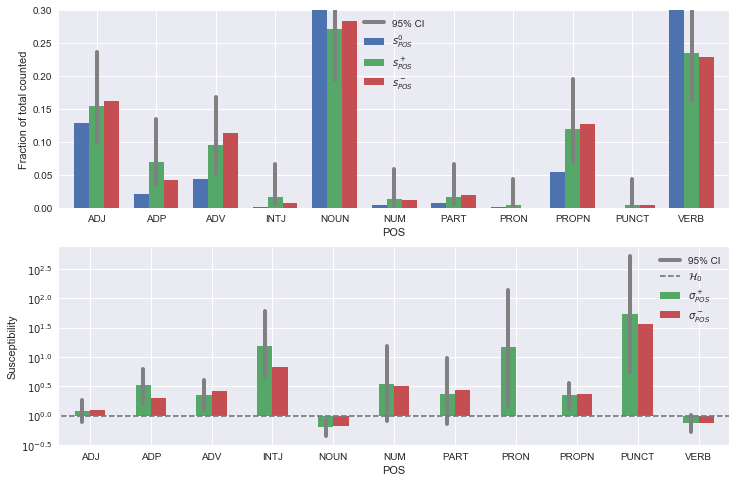

In [12]:
POS_counts, POS_proportions, POS_suscepts = categorical_counts_proportions_suscepts(
    words, 'POS', rename_index=lambda n: nlp.vocab.strings[int(n)])
POS_counts = POS_counts[POS_counts.index != 'X']
POS_proportions = POS_proportions[POS_proportions.index != 'X']
POS_suscepts = POS_suscepts[POS_suscepts.index != 'X']

axes = plot_susties(POS_counts, POS_proportions, POS_suscepts,
                    count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0})
axes[0].set_ylim((0, .3));

### 2.3 "Dependency relation" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in log10

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log10

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in true_divide

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in true_divide



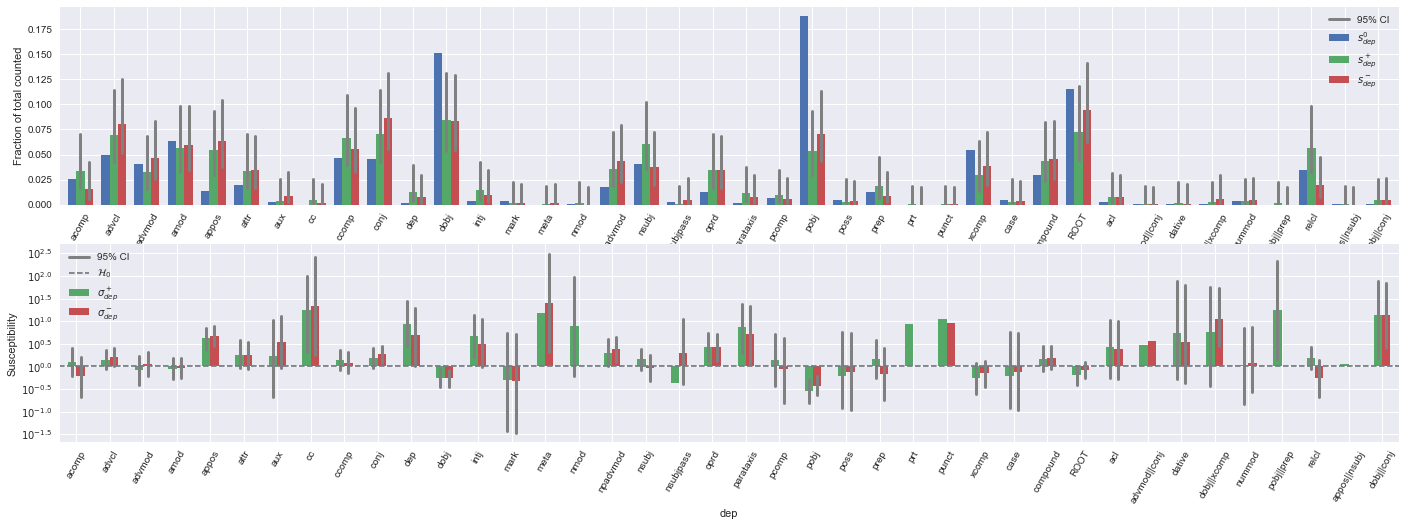

In [13]:
dep_counts, dep_proportions, dep_suscepts = categorical_counts_proportions_suscepts(
    words, 'dep', rename_index=lambda n: nlp.vocab.strings[int(n)])

fig, axes = plt.subplots(2, 1, figsize=(24, 8))
plot_susties(dep_counts, dep_proportions, dep_suscepts,
             axes=axes,
             count_plot_kws={'rot': 60}, suscept_plot_kws={'rot': 60},
             ci_kws={'lw': 3});

### 2.4 "Depth of dependency tree below token" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in log10

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log10



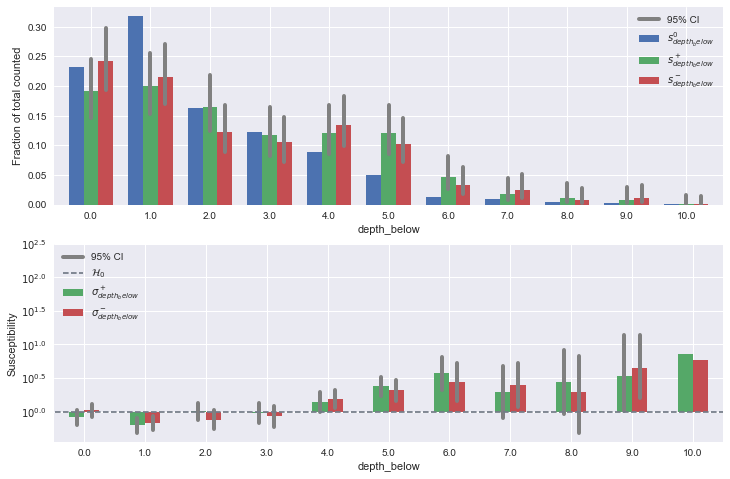

In [14]:
depth_below_counts, depth_below_proportions, depth_below_suscepts = \
    categorical_counts_proportions_suscepts(words, 'depth_below')

plot_susties(depth_below_counts, depth_below_proportions, depth_below_suscepts,
             count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0});

### 2.5 "Depth of dependency tree above token" Susceptibility for appearances, disappearances, compared to parent sentence

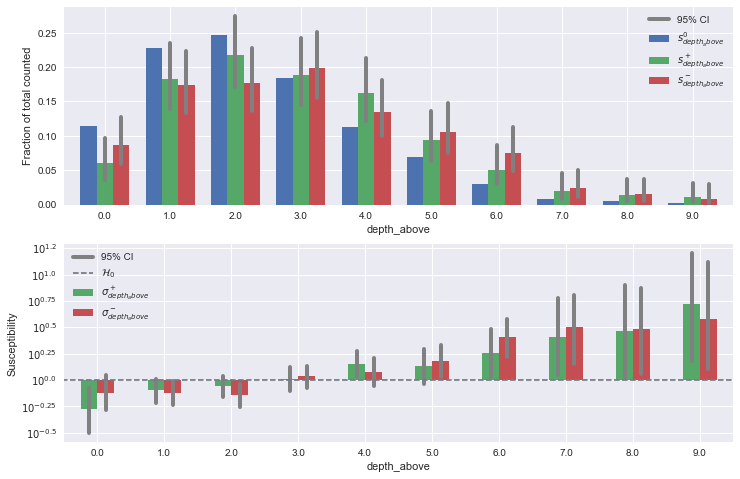

In [15]:
depth_above_counts, depth_above_proportions, depth_above_suscepts = \
    categorical_counts_proportions_suscepts(words, 'depth_above')

plot_susties(depth_above_counts, depth_above_proportions, depth_above_suscepts,
             count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0});

## 3 Appearances and disappearances for continuous variables

### 3.1 Setup

Our plotting function

In [16]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].property
    quantiles = kwargs.get('quantiles', False)
    relative = kwargs.get('relative', False)
    value = data.value_rel if relative else data.value
    binning = kwargs.get('binning', 5)
    tipe = kwargs['tipe']
    ctipe = 'child' if tipe == 'app' else 'parent'
    stripone = kwargs.get('stripone', False)
    
    # Compute binning on reconstituted distribution
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    if not stripone:
        distribution = pd.Series([v for (v, count) in zip(value, data[ctipe + '_count'])
                                  for _ in range(count)])
    else:
        distribution = pd.Series([v for (v, count) in zip(value[value != 1], data[value != 1][ctipe + '_count'])
                                  for _ in range(count)])
    for bin_count in range(binning, 0, -1):
        try:
            _, bins = cut(distribution, bin_count, labels=False,
                          retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    if bin_count <= 1:
        return
    if stripone:
        bins[-1] = 1
    middles = (bins[:-1] + bins[1:]) / 2
    value_bins = np.nan * np.ones_like(value)
    for i in range(bin_count):
        value_bins[(bins[i] <= value) & (value < bins[i + 1])] = i
    value_bins[value == bins[-1]] = bin_count - 1

    # Compute bin heights
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[value_bins == i][tipe + '_count']
                      * data[value_bins == i]['weight_' + tipe]).sum()
        h0s[i] = (data[value_bins == i][ctipe + '_count']
                  * data[value_bins == i]['weight_' + ctipe]).sum()
    total = sum(heights)
    total_h0 = sum(h0s)
    
    # Set any null values of heigths to .5 for confints
    cis = (multinomial_proportions_confint([h or .5 for h in heights.round()],
                                            method='goodman')
           * total_h0 / h0s[:, np.newaxis])
    
    # Plot them
    sigmaphi = (r'\sigma_{\phi}^{'
                + ('+' if tipe == 'app' else '-')
                + '}')
    plt.plot(middles, (heights / total) / (h0s / total_h0), 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${} \mathcal{{H}}_0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.yscale('log')

A helper to plot features in a grid

In [17]:
def plot_grid(data, features, plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data, dropna=False,
                     sharex=False, sharey=True,
                     col='property', hue='property',
                     col_order=features, hue_order=features,
                     col_wrap=6, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
    return g

### 3.2 Features binned by global word distribution in the dataset

#### 3.2.1 Binning by fixed width

##### 3.2.1.1 Absolute values

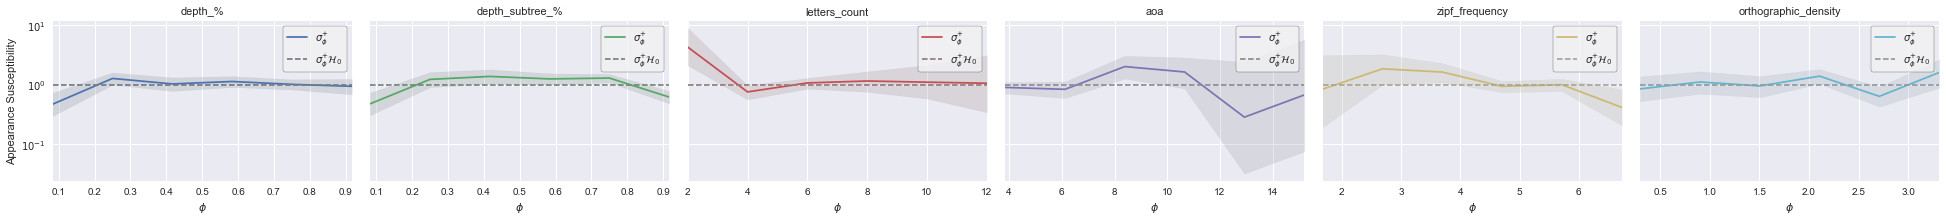

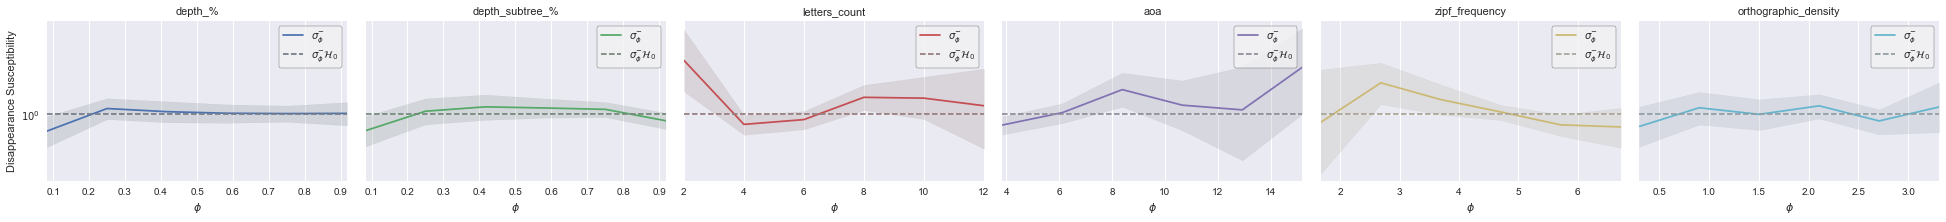

In [18]:
plot_grid(words, continuous_features, plot_bin_susties,
          r'$\phi$', 'Appearance Susceptibility',
          plot_kws={'quantiles': False, 'tipe': 'app', 'binning': 6})

plot_grid(words, continuous_features, plot_bin_susties,
          r'$\phi$', 'Disappearance Susceptibility',
          plot_kws={'quantiles': False, 'tipe': 'dis', 'binning': 6})

##### 3.2.1.2 Sentence-relative values

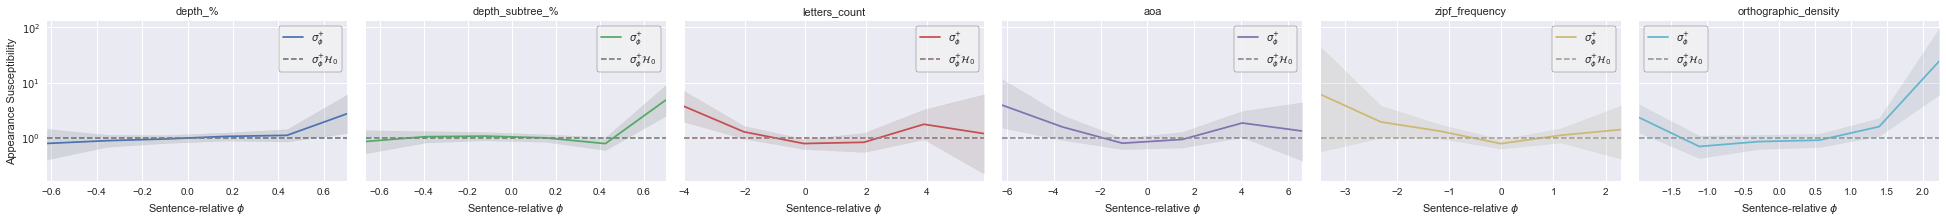

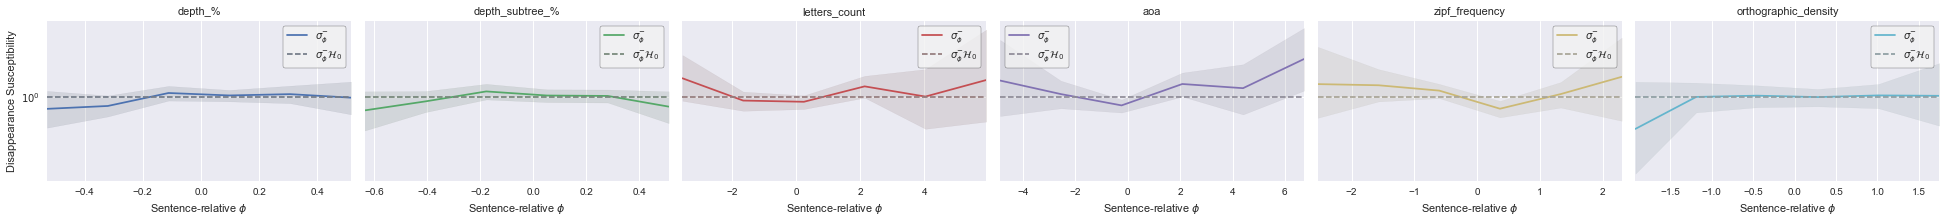

In [19]:
plot_grid(words, continuous_features, plot_bin_susties,
          r'Sentence-relative $\phi$', 'Appearance Susceptibility',
          plot_kws={'quantiles': False, 'tipe': 'app', 'binning': 6, 'relative': True})

plot_grid(words, continuous_features, plot_bin_susties,
          r'Sentence-relative $\phi$', 'Disappearance Susceptibility',
          plot_kws={'quantiles': False, 'tipe': 'dis', 'binning': 6, 'relative': True})

#### 3.2.2 Binning by quantiles

##### 3.2.2.1 Absolute values

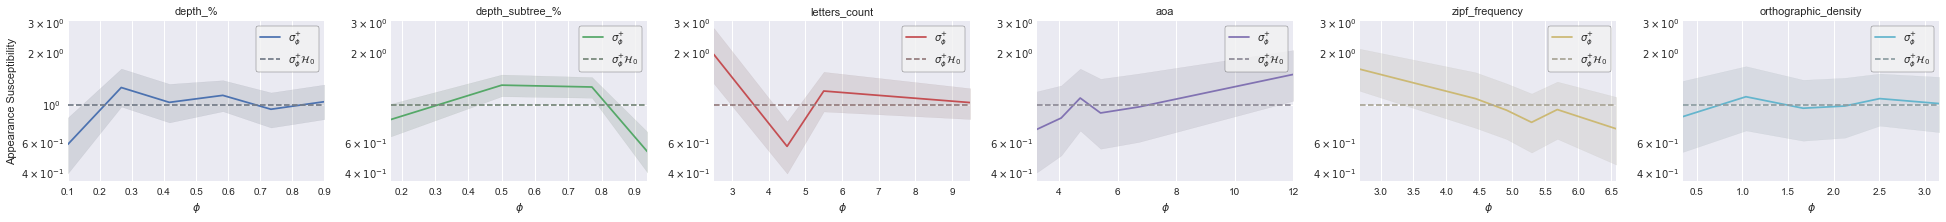

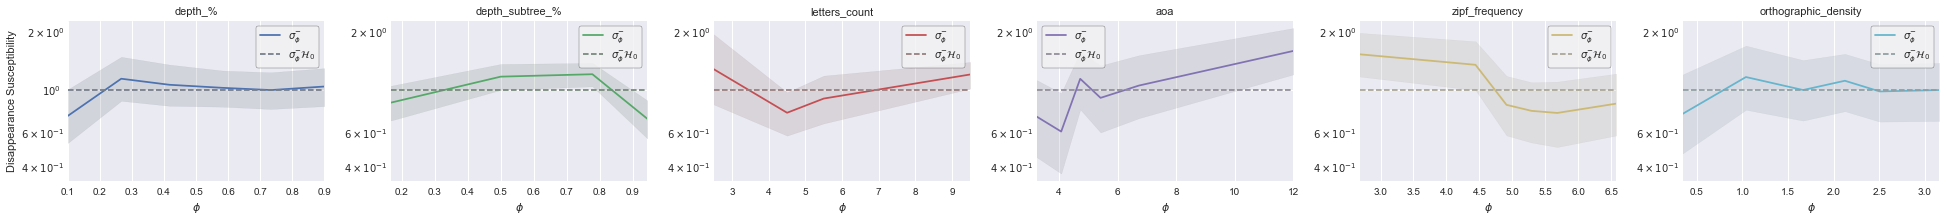

In [20]:
g = plot_grid(words, continuous_features, plot_bin_susties,
              r'$\phi$', 'Appearance Susceptibility',
              plot_kws={'quantiles': True, 'tipe': 'app', 'binning': 6})

# depth_subtree_% has a very skewed distribution (almost all ones),
# so quantile binning never succeeds (there's always overlapping
# bins around the final 1). So we replot it by asking plot_bin_susties()
# to strip the 1 when binning, and re-extend the final bin afterwards.
# We lose the legend for this plot in the process, but that's ok for now.
#plt.sca(g.axes[1])
#plot_bin_susties(data=words[words.property == 'depth_subtree_%'],
#                 quantiles=True, tipe='app', binning=6, stripone=True,
#                 color=sb.color_palette()[1])

g = plot_grid(words, continuous_features, plot_bin_susties,
              r'$\phi$', 'Disappearance Susceptibility',
              plot_kws={'quantiles': True, 'tipe': 'dis', 'binning': 6})

# depth_subtree_% has a very skewed distribution (almost all ones),
# so quantile binning never succeeds (there's always overlapping
# bins around the final 1). So we replot it by asking plot_bin_susties()
# to strip the 1 when binning, and re-extend the final bin afterwards.
# We lose the legend for this plot in the process, but that's ok for now.
#plt.sca(g.axes[1])
#plot_bin_susties(data=words[words.property == 'depth_subtree_%'],
#                 quantiles=True, tipe='dis', binning=6, stripone=True,
#                 color=sb.color_palette()[1])

##### 3.2.2.2 Sentence-relative values

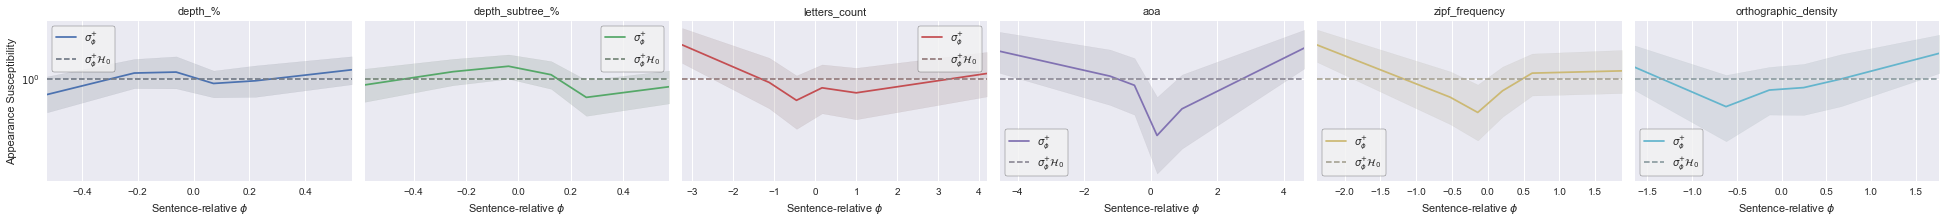

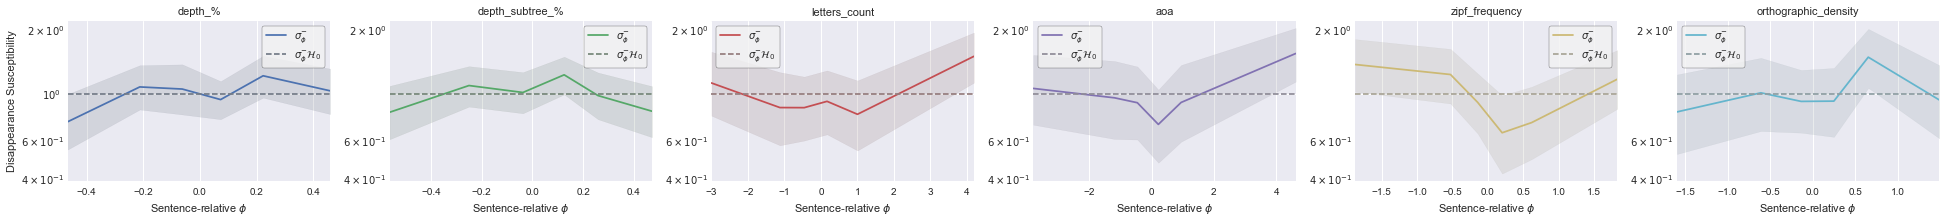

In [21]:
plot_grid(words, continuous_features, plot_bin_susties,
          r'Sentence-relative $\phi$', 'Appearance Susceptibility',
          plot_kws={'quantiles': True, 'tipe': 'app', 'binning': 6, 'relative': True})

plot_grid(words, continuous_features, plot_bin_susties,
          r'Sentence-relative $\phi$', 'Disappearance Susceptibility',
          plot_kws={'quantiles': True, 'tipe': 'dis', 'binning': 6, 'relative': True})

### 3.3 Features placed in the in-sentence word distributions

#### 3.3.1 Setup

Our plotting function

In [22]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].property
    bin_count = kwargs.get('binning', 5)
    tipe = kwargs['tipe']
    ctipe = 'child' if tipe == 'app' else 'parent'
    
    # Compute bin heights
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    step = 1 / bin_count
    for i in range(bin_count):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data[ctipe + '_stop_quantile'])
                          - bound(limits, data[ctipe + '_start_quantile']))
                         / (data[ctipe + '_stop_quantile'] - data[ctipe + '_start_quantile']))
        heights[i] = \
            (contributions * data['weight_' + tipe] * data[tipe + '_count']).sum()
        h0s[i] = (contributions * data['weight_' + ctipe] * data[ctipe + '_count']).sum()
    total = sum(heights)
    total_h0 = sum(h0s)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total_h0 / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, bin_count + 1)
    plt.plot(x, (heights / total) / (h0s / total_h0),
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(h0s), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(x[0], x[-1])
    plt.yscale('log')

#### 3.3.2 Features placed in the in-sentence word distributions

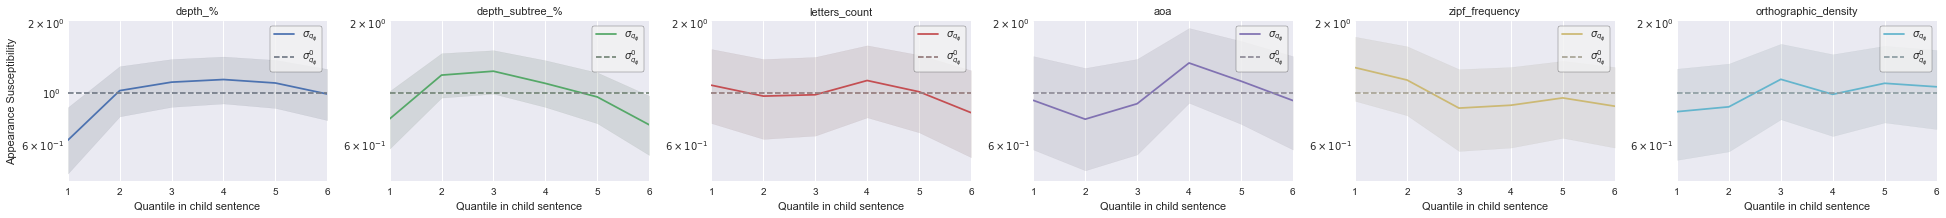

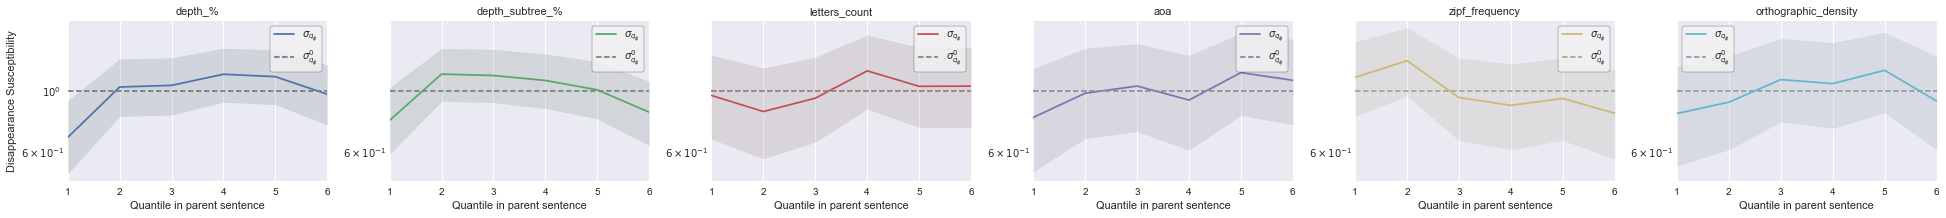

In [23]:
plot_grid(words, continuous_features, plot_sentencequantile_susties,
          'Quantile in child sentence', 'Appearance Susceptibility',
          plot_kws={'tipe': 'app', 'binning': 6})

plot_grid(words, continuous_features, plot_sentencequantile_susties,
          'Quantile in parent sentence', 'Disappearance Susceptibility',
          plot_kws={'tipe': 'dis', 'binning': 6})